In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [56]:
df = web.DataReader('PFE', data_source='yahoo', start= '2016-01-01', end='2021-04-20')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,30.388994,29.952562,30.218216,30.313093,39322421.0,24.864906
2016-01-05,30.588236,30.294119,30.531309,30.531309,28777994.0,25.043903
2016-01-06,30.265656,29.810247,30.104364,29.990513,27242316.0,24.600302
2016-01-07,30.180265,29.544592,29.563566,29.791271,39223134.0,24.436874
2016-01-08,30.009487,29.335863,29.933586,29.411764,34840286.0,24.125578
...,...,...,...,...,...,...
2021-04-14,37.380001,36.959999,37.169998,37.169998,23842900.0,37.169998
2021-04-15,37.740002,37.259998,37.259998,37.599998,24945800.0,37.599998
2021-04-16,38.700001,37.810001,37.869999,38.570000,52715300.0,38.570000


In [27]:
df.shape

(1334, 6)

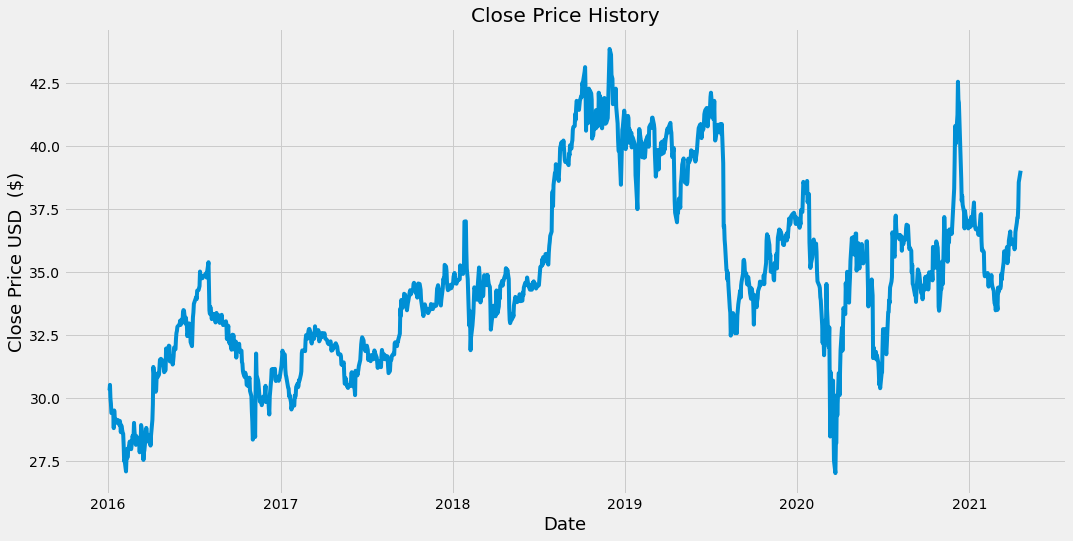

In [57]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD  ($)', fontsize=18)
plt.show()

In [30]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1068

In [58]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.19503943],
       [0.20800446],
       [0.17587372],
       ...,
       [0.70700223],
       [0.71294352],
       [0.7426504 ]])

In [59]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 60:
      print(x_train)
      print(y_train)
      print()

[array([0.19503943, 0.20800446, 0.17587372, 0.16403603, 0.14148809,
       0.14543399, 0.14148809, 0.10597512, 0.14768877, 0.13077785,
       0.1240135 , 0.12232238, 0.11781282, 0.12514083, 0.11330325,
       0.12288616, 0.11443059, 0.09639233, 0.11273958, 0.09470121,
       0.09301009, 0.06651626, 0.02874851, 0.03043962, 0.00394578,
       0.03438552, 0.05636979, 0.03607664, 0.04904166, 0.07440805,
       0.06426147, 0.05975191, 0.05636979, 0.08793675, 0.08286352,
       0.08624575, 0.11837648, 0.09808333, 0.06651626, 0.08737319,
       0.08399096, 0.07891773, 0.06877115, 0.07328072, 0.04904166,
       0.07046216, 0.06200669, 0.11330325, 0.09075531, 0.05918824,
       0.03100329, 0.04791422, 0.0541149 , 0.0890642 , 0.10653879,
       0.09582866, 0.08962786, 0.07271694, 0.08793675, 0.0890642 ])]
[0.0648252551971511]



In [60]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [61]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape 

(1008, 60, 1)

In [62]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))


In [63]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1008/1008 [==============================] - 26s 23ms/step - loss: 0.0118


In [65]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [66]:
x_test = np.array(x_test)

In [67]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [68]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [69]:
rmse = np.sqrt( np.mean( predictions - y_test)**2)
rmse

0.727322642964528

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


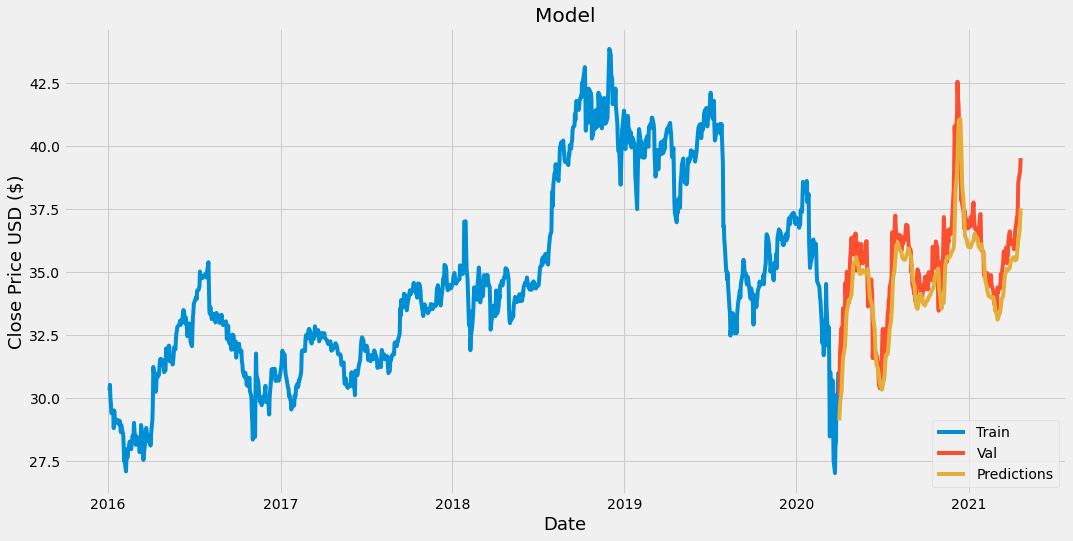

In [70]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid[ 'Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc= 'lower right')
plt.show()

In [71]:
valid 

,Close,Predictions
Date,,
2020-04-01,30.123341,29.122189
2020-04-02,31.185959,29.478378
2020-04-03,31.916510,29.857590
2020-04-06,32.798862,30.295795
2020-04-07,31.888046,30.825994
...,...,...
2021-04-15,37.599998,36.042549
2021-04-16,38.570000,36.284966
2021-04-19,38.930000,36.664509


In [72]:
pfizer_quote = web.DataReader('PFE', data_source='yahoo', start='2016-01-01', end='2021-04-20')
new_df = pfizer_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[37.538]]


In [73]:
pfizer_quote2 = web.DataReader('PFE', data_source='yahoo', start='2021-04-21', end='2021-04-21')
print(pfizer_quote2['Close'])


Date
2021-04-21    39.529999
Name: Close, dtype: float64
